In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

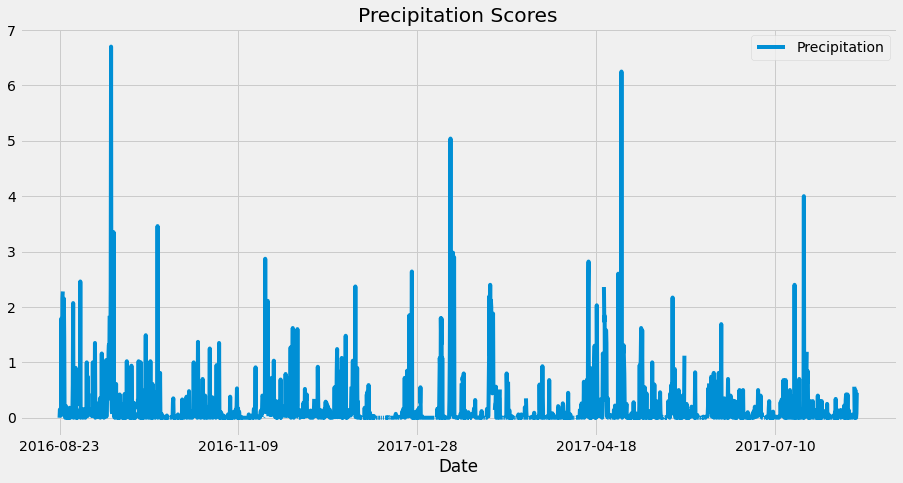

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
year_ago


# Perform a query to retrieve the data and precipitation scores
precipitation_scr = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).order_by(Measurement.date).all()
precipitation_scr


# Save the query results as a Pandas DataFrame and set the index to the date column
scores = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).all()
scores

# Sort the dataframe by date
precipitation_scr_df = pd.DataFrame(precipitation_scr, columns=['Date', 'Precipitation'])
precipitation_scr_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
x = "Date"
y = "Precipitation"
precipitation_scr_df.plot(x, y, title="Precipitation Scores", figsize=(14,7))
plt.show()



In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_scr_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset

stations = session.query(Measurement.station).distinct().count()
stations

9

In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
station_count = session.query(func.count(Station.id)).all()
station_count
# List the stations and the counts in descending order.


[(9,)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

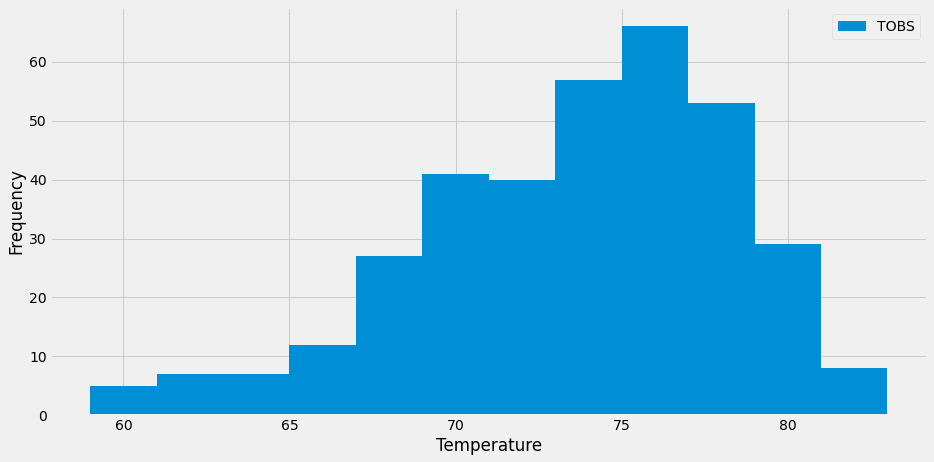

In [15]:
# Using the most active station id
calculate_temperature = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]

most_active_id = session.query(*calculate_temperature).filter(Measurement.station == 'USC00519281').all()
most_active_id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


tobs_data = session.query(Measurement.tobs).filter(Measurement.date >= year_ago). filter(Measurement.station == 'USC00519281').order_by(Measurement.date).all()
tobs_data

tobs_df = pd.DataFrame(tobs_data, columns=['TOBS'])


tobs_df.plot.hist(bins= 12, figsize=(14,7))
plt.xlabel('Temperature')
plt.show()


In [16]:
# Close Session
#session.close()

 Compare June and December data across all years

In [17]:
import scipy.stats as stats
from random import sample

In [18]:
# return the raw data from each month, June and December
june_temperature = session.query(Measurement.date, Measurement.tobs).filter(func.strftime("%m",Measurement.date) == '06').all()
december_temperature = session.query(Measurement.date, Measurement.tobs).filter(func.strftime("%m",Measurement.date) == '12').all()

# convert raw data to DataFrames to label them and then concatenate into one DataFrame
june_temperature_df = pd.DataFrame(june_temperature,columns=["Date","Temperature"])
december_temperature_df = pd.DataFrame(december_temperature,columns=["Date","Temperature"])
june_temperature_df["Month"] = "June"
december_temperature_df["Month"] = "December"
temperature_df = pd.concat([june_temperature_df,december_temperature_df], ignore_index=True)

# calculate the average for both June and December
avg_temp_month = temperature_df.groupby("Month").mean()
avg_temp_month

,Temperature
Month,
December,71.041529
June,74.944118


In [19]:
# Filter data for desired months
# Identify the average temperature for June
june_temperature = session.query(Measurement.date, Measurement.station, func.avg(Measurement.tobs)).\
    filter(func.strftime("%m", Measurement.date) == "06").\
    group_by(Measurement.station, Measurement.date).all()

In [20]:
# Filter data for desired months
# Identify the average temperature for December
december_temperature = session.query(Measurement.date, Measurement.station, func.avg(Measurement.tobs)).\
    filter(func.strftime("%m", Measurement.date) == "12").\
    group_by(Measurement.station, Measurement.date).all()

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

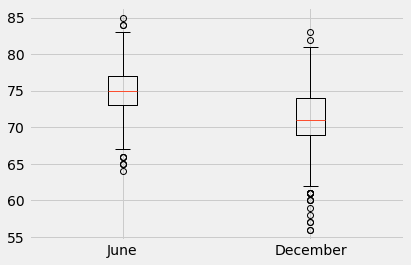

In [21]:
# Create collections of temperature data
# Run paired t-test
box_data = [june_temperature_df["Temperature"],december_temperature_df["Temperature"]]
plt.boxplot(box_data,labels=['June', 'December']);
stats.ttest_ind(june_temperature_df["Temperature"], december_temperature_df["Temperature"])

# Close session

In [23]:
# Close Session
session.close()